### 读取数据

In [4]:
import  pandas as pd
import  numpy  as np
df = pd.read_excel("data.xlsx")
df.describe()

,id,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_index,cons_conf_index,lending_rate3m,nr_employed,subscribe
count,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000
mean,11250.500000,40.407511,1146.303733,3.364800,773.991956,1.316444,0.078529,93.548785,-39.877180,3.302490,5137.211285,0.131200
std,6495.334864,12.086078,1432.432125,7.223837,326.934334,1.918733,1.573831,2.805786,5.805442,1.611777,170.670611,0.337626
min,1.000000,16.000000,0.000000,0.000000,0.000000,0.000000,-3.400000,87.640000,-53.280000,0.600000,4715.420000,0.000000
25%,5625.750000,32.000000,143.000000,1.000000,557.750000,0.000000,-1.800000,91.190000,-44.160000,1.430000,5008.510000,0.000000
50%,11250.500000,38.000000,353.000000,1.000000,964.000000,0.000000,1.100000,93.540000,-40.600000,3.920000,5133.955000,0.000000
75%,16875.250000,47.000000,1873.000000,3.000000,1005.000000,2.000000,1.400000,95.920000,-35.797500,4.830000,5267.677500,0.000000
max,22500.000000,101.000000,5149.000000,57.000000,1048.000000,6.000000,1.400000,99.460000,-25.550000,5.270000,5489.500000,1.000000


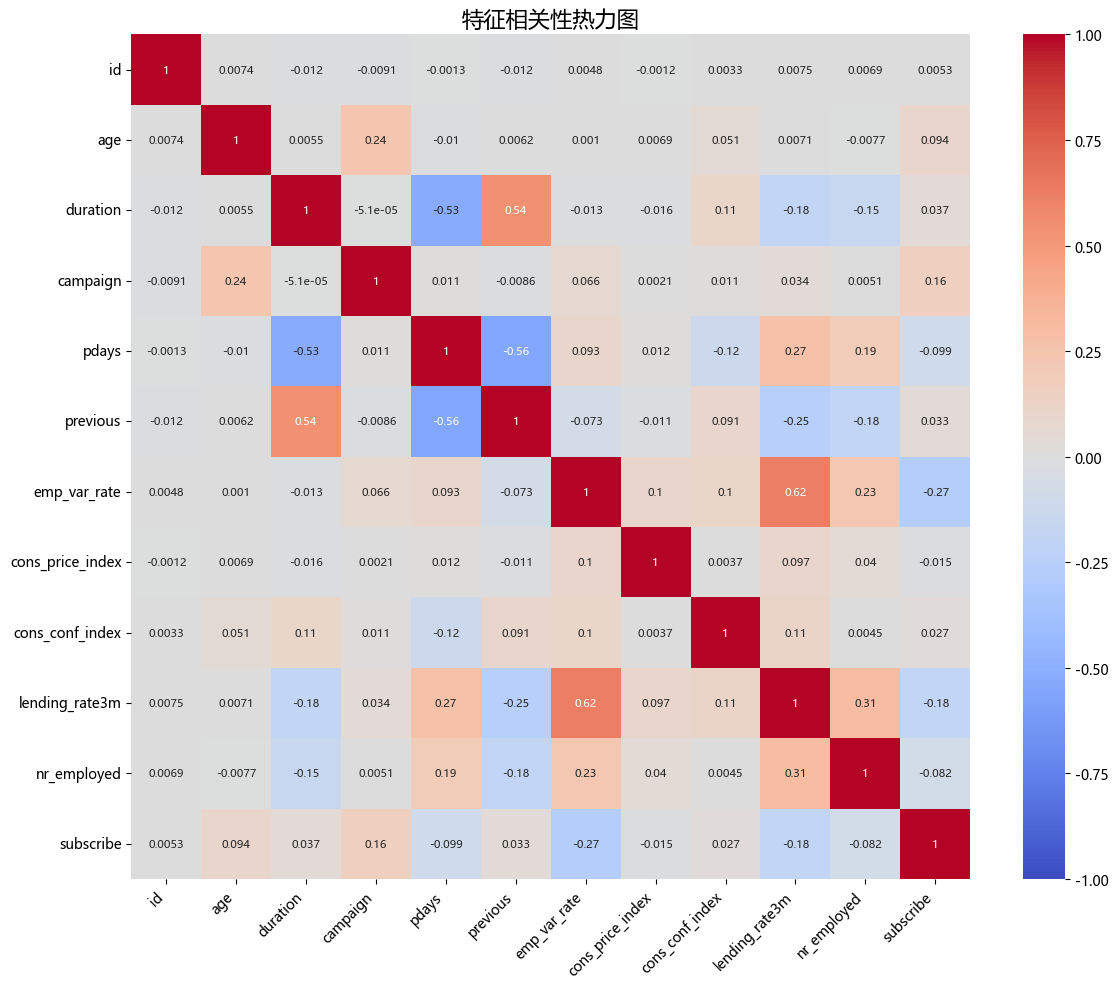

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体，防止中文乱码
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_excel("data.xlsx")

# 只保留数值型列
num_df = df.select_dtypes(include=[np.number])

# 计算相关性矩阵
corr = num_df.corr()

# 绘制热力图并导出为jpg
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr, 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    annot_kws={"size": 8}
)
plt.title('特征相关性热力图', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('heatmap.jpg', dpi=300)
plt.show()  

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 1. 读取数据
df = pd.read_excel("data.xlsx", sheet_name="data")
df = df[df["default"] != "unknown"]
df.drop(columns=["id", "age_group", "education_level"], inplace=True)
df = pd.get_dummies(df, drop_first=True)

X = df.drop(columns=["subscribe"])
y = df["subscribe"]

# 2. 划分训练集/测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 处理样本不平衡（SMOTE）
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 4. 设置参数搜索范围
param_dist = {
    'max_depth': np.arange(4, 16, 2),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': np.arange(100, 600, 100),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# 5. 随机搜索（RandomizedSearchCV）
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=200,
    scoring='f1',
    cv=10,
    verbose=1,
    n_jobs=-1,
    random_state=42
)



In [10]:
# 6. 记录开始时间
start_time = time.time()

# 7. 训练模型
random_search.fit(X_resampled, y_resampled)

# 8. 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

# 9. 输出最优参数与评分
print("✅ Best Parameters:")
print(random_search.best_params_)
print("🏆 Best F1 Score:")
print(random_search.best_score_)

# 10. 最佳模型预测
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:59:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Total training time: 466.96 seconds
✅ Best Parameters:
{'subsample': 0.8, 'n_estimators': np.int64(500), 'min_child_weight': 1, 'max_depth': np.int64(14), 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}
🏆 Best F1 Score:
0.905330917573092



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3036
           1       0.60      0.40      0.48       492

    accuracy                           0.88      3528
   macro avg       0.75      0.68      0.71      3528
weighted avg       0.87      0.88      0.87      3528

🧮 Confusion Matrix:
[[2904  132]
 [ 293  199]]


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39118 (\N{CJK UNIFIED IDEOGRAPH-98CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38505 (\N{CJK UNIFIED IDEOGRAPH-9669}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


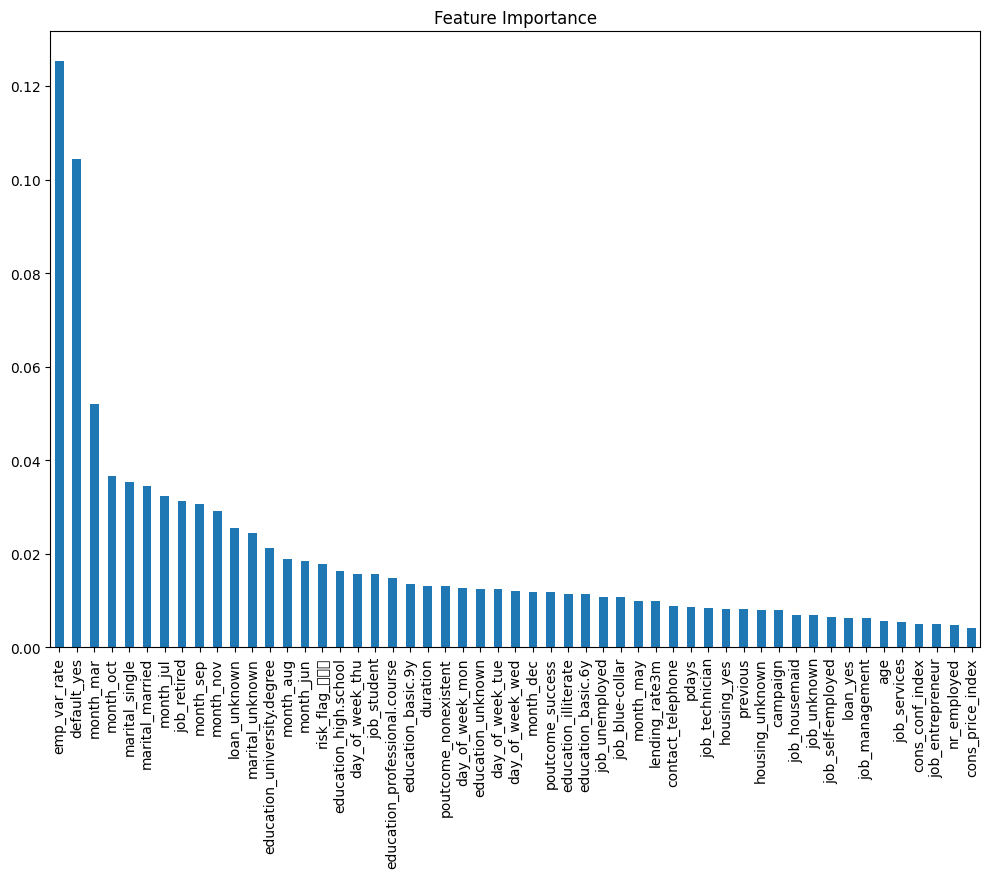

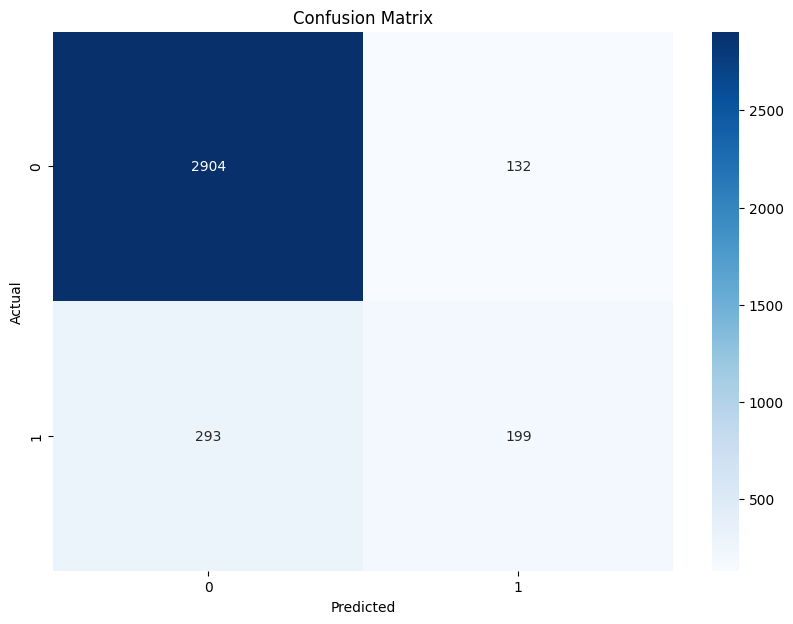

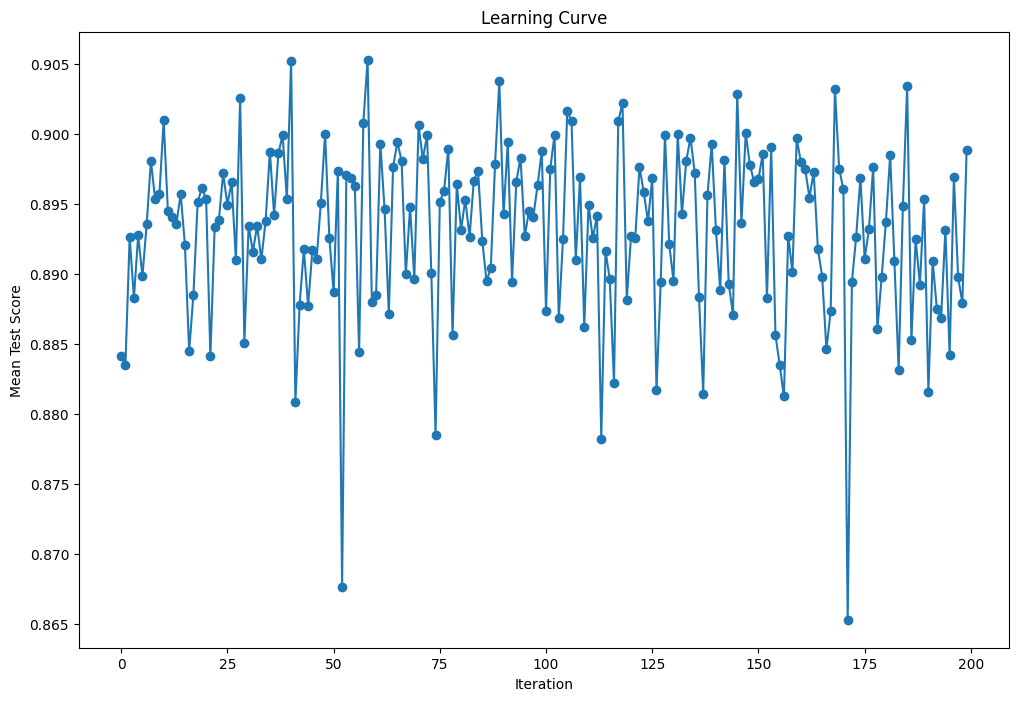

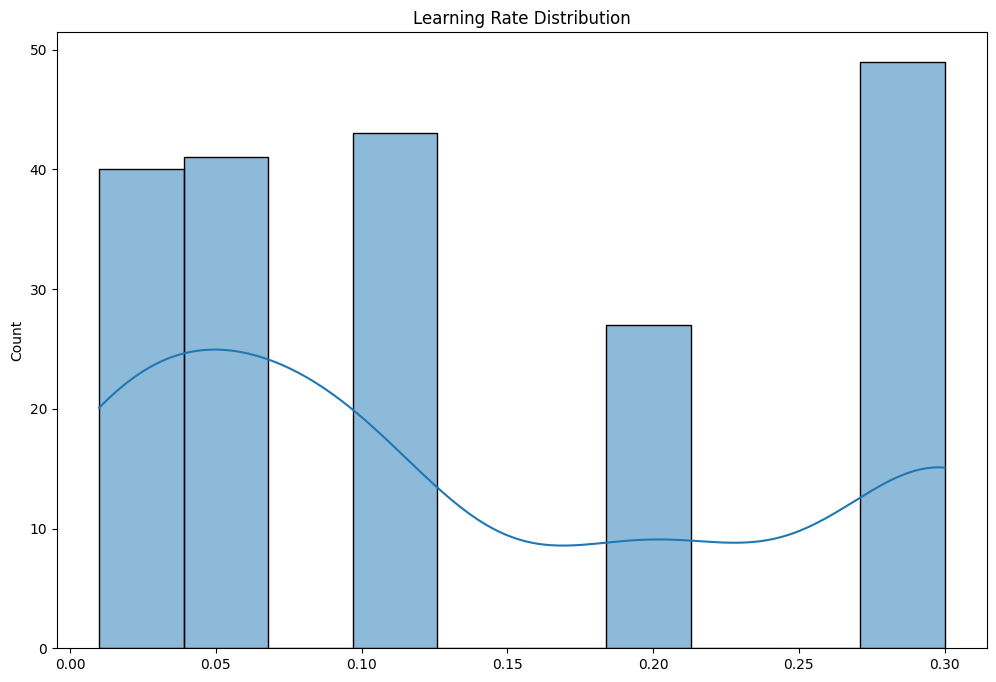

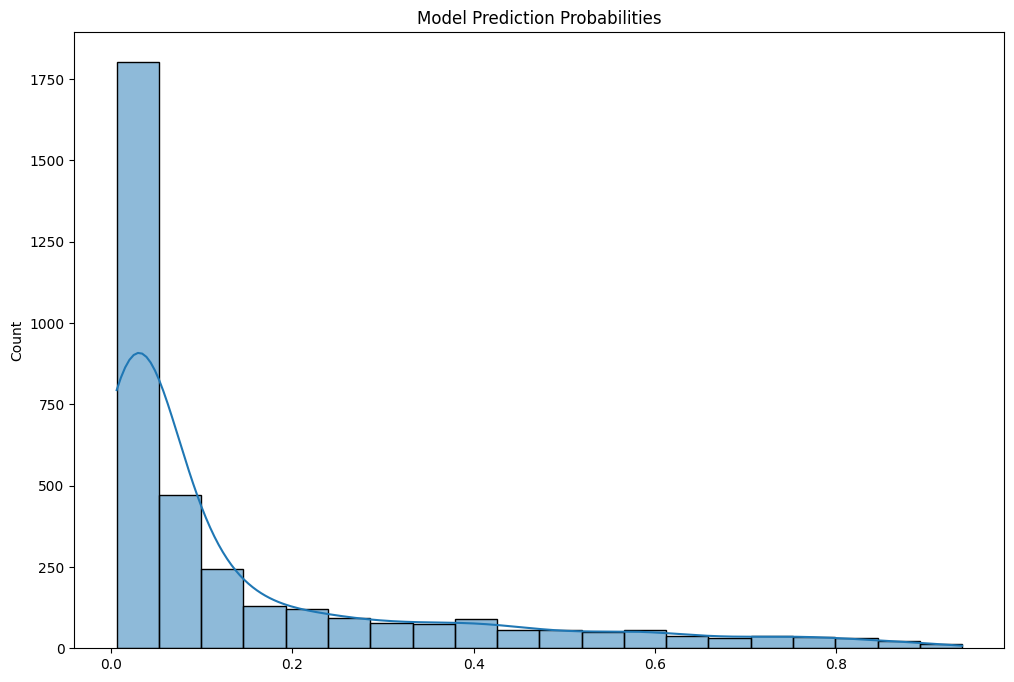

In [11]:
# 11. 输出结果
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 12. 绘制特征重要性
plt.figure(figsize=(12, 8))
pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance')
plt.show()

# 13. 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# 14. 绘制学习曲线
results = random_search.cv_results_
plt.figure(figsize=(12, 8))
plt.plot(results['mean_test_score'], 'o-')
plt.title('Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('Mean Test Score')
plt.show()

# 15. 绘制超参数分布
plt.figure(figsize=(12, 8))
sns.histplot(results['param_learning_rate'], bins=10, kde=True)
plt.title('Learning Rate Distribution')
plt.show()

# 16. 绘制模型预测概率
plt.figure(figsize=(12, 8))
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
sns.histplot(y_pred_proba, bins=20, kde=True)
plt.title('Model Prediction Probabilities')
plt.show()